In [6]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, Reshape, LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn.svm
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from keras import backend as K

In [8]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
tree_path = '../input/dataset-master/dataset-master/Annotations'
image_path = '../input/dataset-master/dataset-master/JPEGImages'

In [ ]:
image = cv2.imread(image_path+'/BloodImage_00002.jpg')
tree = ET.parse(tree_path+'/BloodImage_00002.xml')

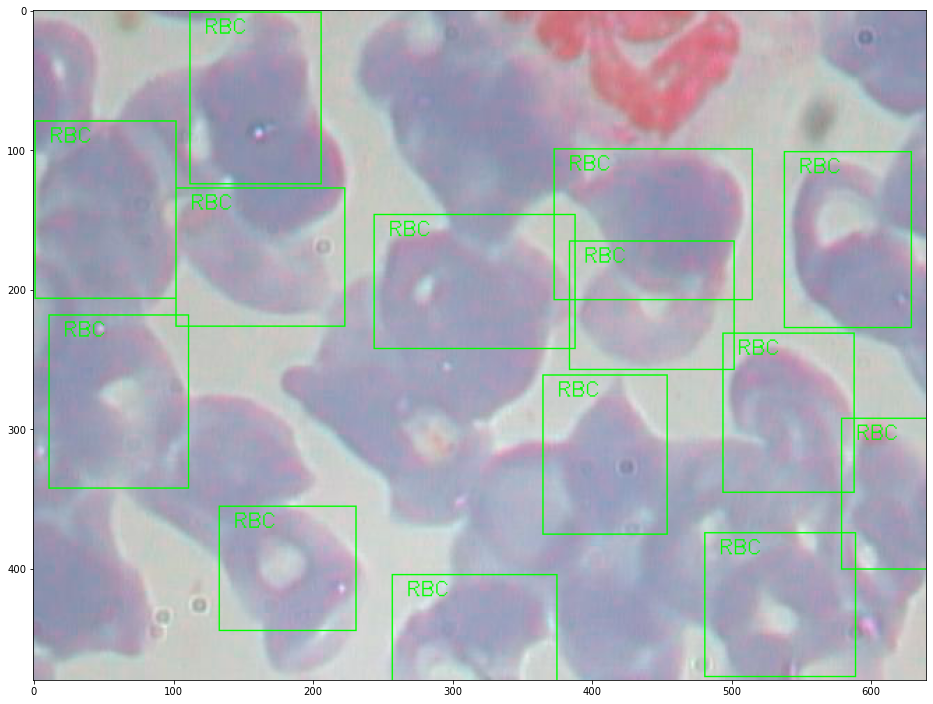

In [10]:
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

In [11]:
df1 = pd.read_csv('../input/dataset-master/dataset-master/labels.csv')
df1 = df1.drop(columns=['Unnamed: 0']).dropna()
df1

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
...,...,...
405,405,NEUTROPHIL
407,407,NEUTROPHIL
408,408,NEUTROPHIL
409,409,NEUTROPHIL


In [12]:
y3 = df1[~df1["Category"].str.contains(",", na=False)]['Category']
y3

0      NEUTROPHIL
1      NEUTROPHIL
2      NEUTROPHIL
3      NEUTROPHIL
4      NEUTROPHIL
          ...    
405    NEUTROPHIL
407    NEUTROPHIL
408    NEUTROPHIL
409    NEUTROPHIL
410    EOSINOPHIL
Name: Category, Length: 352, dtype: object

[  3  88  33  21 207]


/opt/anaconda3/envs/imageproc/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0, 0.5, 'Number of Cells')

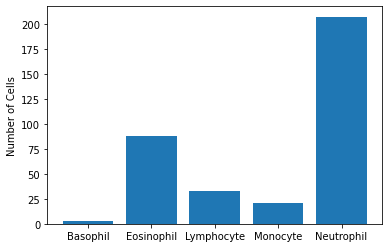

In [13]:
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Number of Cells')

In [14]:
def get_data(folder):

    X = []
    y = []
    for wbc_type in os.listdir(folder):
        print(wbc_type)
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
            elif wbc_type in ['MONOCYTE']:
                label = 3  
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(80,60), interpolation=cv2.INTER_CUBIC)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)

    return X,y,z
X_train, y_train = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')

from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
print(class1)

  2%|▏         | 49/2499 [00:00<00:05, 482.54it/s]

NEUTROPHIL


  2%|▏         | 57/2478 [00:00<00:04, 566.20it/s]

.DS_Store
MONOCYTE


  2%|▏         | 58/2497 [00:00<00:04, 579.25it/s]

EOSINOPHIL


  2%|▏         | 53/2483 [00:00<00:04, 523.76it/s]

LYMPHOCYTE


  8%|▊         | 53/624 [00:00<00:01, 528.95it/s]

NEUTROPHIL


  8%|▊         | 52/620 [00:00<00:01, 513.96it/s]

MONOCYTE


  5%|▍         | 31/623 [00:00<00:02, 293.93it/s]

EOSINOPHIL


 10%|█         | 63/620 [00:00<00:00, 623.14it/s]

LYMPHOCYTE


100%|██████████| 620/620 [00:01<00:00, 577.25it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


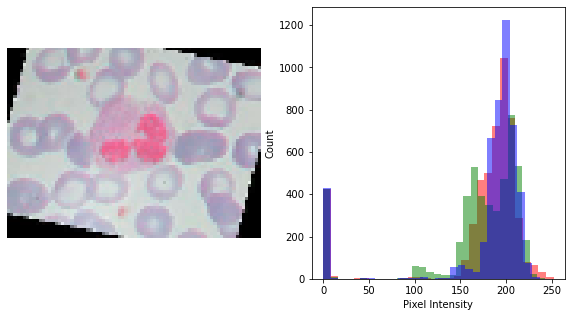

In [15]:
def plotHistogram(a):
    #Plot histogram of RGB Pixel Intensities
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

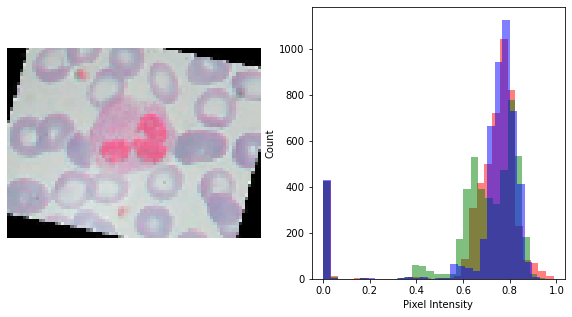

In [16]:
X_train=np.array(X_train)
X_train=X_train/255.0
X_test=np.array(X_test)
X_test=X_test/255.0
plotHistogram(X_train[1])

In [17]:
def rgb_to_grayscale(input):
    return K.mean(input, axis=3)
def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]

In [18]:
# Helper Functions  Learning Curves and Confusion Matrix
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [26]:
def runKerasCNNAugment(a,b,c,d,e, epochs, classes):
    
    batch_size = 128
    num_classes = len(b[0])
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    input_tensor = Input(shape=input_shape)
    
    #CNN
    modelcnn = Sequential()
    modelcnn.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    modelcnn.add(Conv2D(64, (3, 3), activation='relu'))
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))
    modelcnn.add(Flatten())
    cnn_output = modelcnn(input_tensor)
    
    #RNN    
    modelrnn = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
    modelrnn = LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)(modelrnn)
    rnn_output = LSTM(64, dropout=0.25, recurrent_dropout=0.25)(modelrnn)

    #Merger
    merge_layer = concatenate([cnn_output, rnn_output])
    last_process = Dense(128, activation='relu')(merge_layer)
    last_process = Dropout(0.5)(last_process)
    output_tensor = Dense(num_classes, activation='softmax')(last_process)
    model = Model(input=input_tensor, output=output_tensor)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])    
    datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        zoom_range=0.1,
        rotation_range=10, 
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,  
        vertical_flip=False) 
    history = model.fit_generator(datagen.flow(a,b, batch_size=32), steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = classes 
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    

In [27]:
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1, 30, class1)

/opt/anaconda3/envs/imageproc/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/30
312/311 [==============================] - 178s 572ms/step - loss: 1.4881 - accuracy: 0.2661 - val_loss: 1.3144 - val_accuracy: 0.4097
Epoch 2/30
312/311 [==============================] - 185s 594ms/step - loss: 1.3180 - accuracy: 0.3622 - val_loss: 1.1486 - val_accuracy: 0.4769
Epoch 3/30
312/311 [==============================] - 186s 595ms/step - loss: 1.2127 - accuracy: 0.4410 - val_loss: 1.2083 - val_accuracy: 0.3438
Epoch 4/30
312/311 [==============================] - 226s 723ms/step - loss: 1.1229 - accuracy: 0.4827 - val_loss: 1.3642 - val_accuracy: 0.3683
Epoch 5/30
312/311 [==============================] - 181s 580ms/step - loss: 0.9976 - accuracy: 0.5543 - val_loss: 0.7998 - val_accuracy: 0.5907
Epoch 6/30
312/311 [==============================] - 243s 777ms/step - loss: 0.8694 - accuracy: 0.6082 - val_loss: 0.9750 - val_accuracy: 0.5420
Epoch 7/30
312/311 [==============================] - 255s 816ms/step - loss: 0.7824 - accuracy: 0.6469 - val_loss: 0.5981 -